## Things we are interested in
- Structural changes of wallet behavior
- Privacy – anything we can find, anyone else can (fix!)
- Payments over Bitcoin – dynamics of user and wallet behavior
- Fees – a good statistical model, and general behavior description

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

# some pandas options
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.set_option("display.expand_frame_repr", False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

sats = 100000000

# transactions that are believed to be payments 
- Transactions with two or less outputs (TX2OL)
- Considered *most likely* 
- Does this transaction set has enough volume and economic value to be worth studying?
- Yes, about 50% of value being transacted (next slide - yes with a graph)

In [8]:
%%bigquery txs_two_or_less_vs_everything
SELECT
  txs.block_year,
  txs.total AS txs_two_or_less,
  total.total AS txs_total,
  txs.total_btc AS btc_two_or_less,
  total.total_btc AS btc_total,
FROM (
  SELECT
    DATE_TRUNC(block_timestamp, year) block_year,
    COUNT(*) AS total,
    SUM(output_value) / 100000000 AS total_btc
  FROM
    `bitcoin-data-analysis-320014.transaction_analysis.txs_two_or_less_outputs`
  GROUP BY
    1) txs
JOIN (
  SELECT
    DATE_TRUNC(block_timestamp, year) block_year,
    COUNT(*) AS total,
    SUM(output_value) / 100000000 AS total_btc
  FROM
    `bigquery-public-data.crypto_bitcoin.transactions`
  GROUP BY
    1 ) total
ON
  txs.block_year = total.block_year

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.42rows/s]


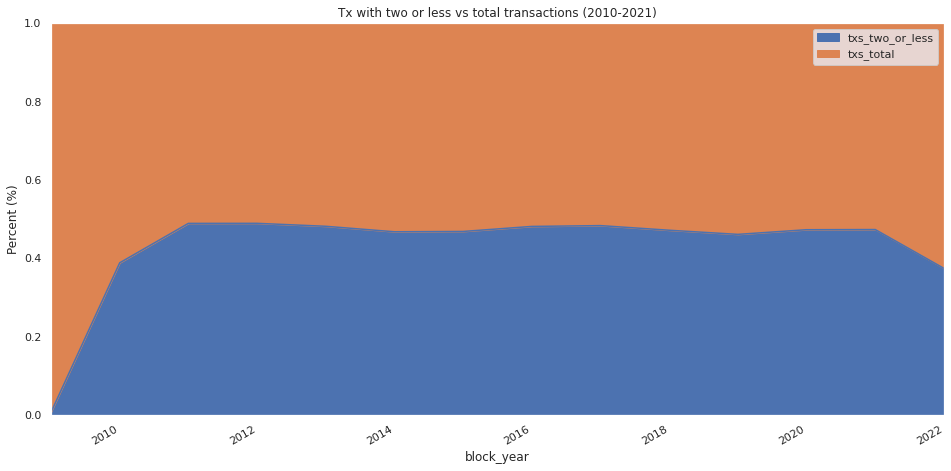

In [9]:
txs_dt = txs_two_or_less_vs_everything.set_index(
    pd.DatetimeIndex(txs_two_or_less_vs_everything['block_year'])
).drop('block_year', axis=1)[['txs_two_or_less', 'txs_total']]

txs_dt = txs_dt.divide(txs_dt.sum(axis=1), axis=0)

# df = df.divide(df.sum(axis=1), axis=0)
ax = txs_dt.plot(kind='area', stacked=True, title='Tx with two or less vs total transactions (2010-2021)', figsize=(16,8))

ax.set_ylabel('Percent (%)')
ax.autoscale(enable=True, axis='both', tight=True)

plt.show()

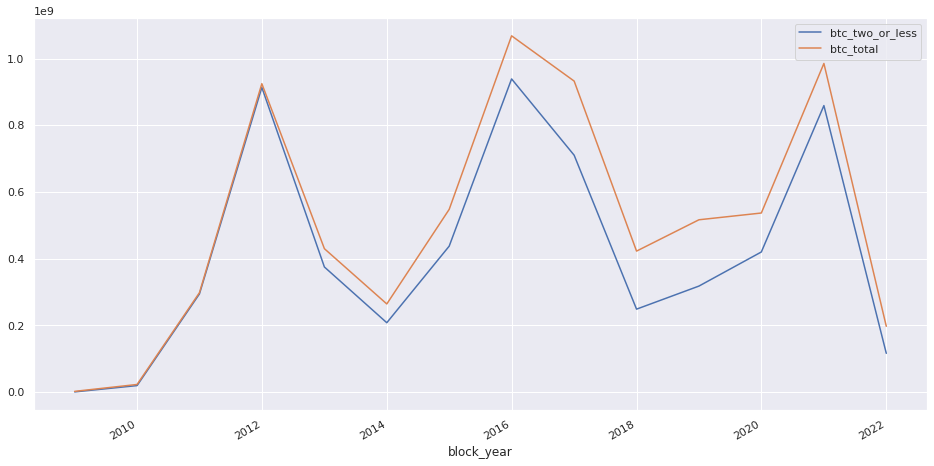

In [22]:
total_btc_dt = txs_two_or_less_vs_everything.set_index(
    pd.DatetimeIndex(txs_two_or_less_vs_everything['block_year'])
).drop('block_year', axis=1)[['btc_two_or_less', 'btc_total']]

# weird converstion because one column came back as object dtype??
total_btc_dt['btc_total'] = total_btc_dt['btc_total'].astype(float)
total_btc_dt.plot(figsize=(16,8), legend="Total BTC");

# Determing the payment value
*finding the change transaction*
- Single Output
- Return Change To Input Address
- Matching Address Type
- Previously Seen Address
- Nonstandard
- Unknown

In the following graph we can already see some interesting things

# Determing the payment value

In order to say anything meaningful about a payment transaction, we must first attempt to identify which of the outputs is the payment and which output is the change. To do this, we apply the following heuristics to our TX2OL set:

#### Single Output

In the simple case, the payment value is the single output as there is no change. While these are included in our set, it is less likely that these are payment transactions and more likely that they are moving Bitcoin between wallets or UTXO consolidation transactions. These are excluded for now.

#### Nonstandard

Nonstandard transactions have two outputs, but one or both of the outputs are non-standard. In the case where one output is standard, this is assumed to be the payment. These also are unlikely to be payments and thus excluded for now.

#### Return Change To Input Address

In the case where one of the outputs is to an address used in the inputs, it is easy to identify the reused output as a change address. This is an example of address re-use.

#### Matching Address Type

If the inputs are all of the same type (segwit: bc1) and the outputs are mixed (legacy: 1XX, segwit: bc1), we can reasonably assume that the segwit output is the change address. In this scenario, the payee has a different address type than the payer, and the payer's wallet generates a fresh address for the change, which will necessarily match the address type used for the inputs as they are all coming from the same wallet.

#### Previously Seen Address

This is another example of address re-use which helps identify the payment value. If the tx has two outputs and one of the outputs is to an address which has been previously used in a _different_ transaction, this is likely the payment. For this, we only consider txs where one of the outputs to a previously used address and the other output has never been seen before. This is because the never before seen address is most likely a fresh address generated by the wallet as the change address

#### Unknown

For all others, we cannot reasonably say which is the change and which is the payment, so we leave those values as null for now.

### Heuristics Over Time

In the graph below, we look at each of these categories as a percentage of all TX2OL. 

In [25]:
%%bigquery yearly_change
SELECT *, total / SUM(total) OVER(partition by block_year) AS percent
  FROM (
SELECT DATE_TRUNC(block_timestamp, year) block_year
     , heuristic
     , count(*) AS total
  FROM `bitcoin-data-analysis-320014.transaction_analysis.txs_two_or_less_outputs`
 GROUP BY 1,2
)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 49.62rows/s]


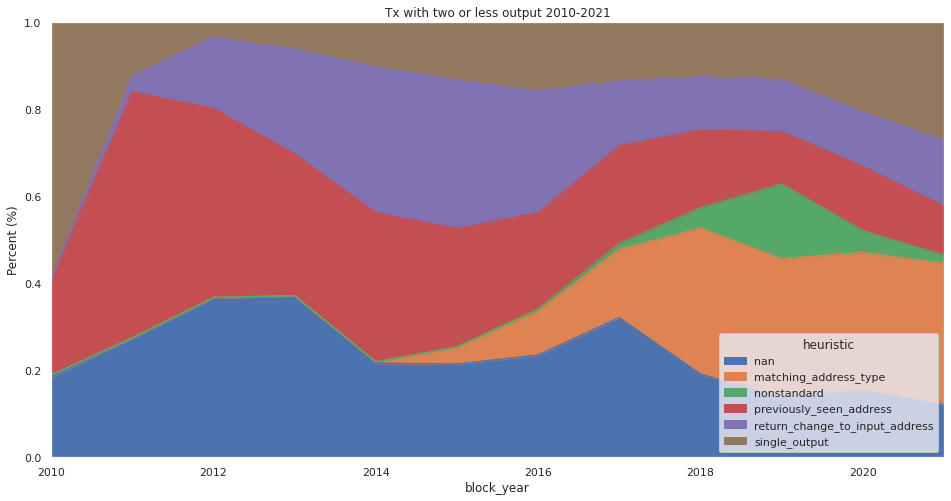

In [26]:
yc_dt = yearly_change.set_index(pd.to_datetime(yearly_change['block_year'], format='%Y-%m-%d'))
df = yc_dt.pivot(columns='heuristic', values='percent')["2010":"2021"]


# df = df.divide(df.sum(axis=1), axis=0)
ax = df.plot(kind='area', stacked=True, title='Tx with two or less output 2010-2021', figsize=(16,8))

ax.set_ylabel('Percent (%)')
ax.autoscale(enable=True, axis='both', tight=True)

plt.show()

In [28]:
# yc_dt.pivot(columns='heuristic', values='total')["2010":"2021"].sort_index(ascending=False).style.format("{:,.0f}")

# USD value of transactions

For each heurist, we consider the mean and median USD value over time. For the payment value, this seems to fall with in a reasonable range for a "payment." We also observe change values to be much higher.

In [34]:
%%bigquery usd_by_heuristic
SELECT DATE_TRUNC(block_timestamp, year) block_year
     , heuristic
     , APPROX_QUANTILES(payment_usd, 100)[OFFSET(50)] as approx_median_payment_usd
     , AVG(payment_usd) AS average_payment_usd
     , APPROX_QUANTILES(change_usd, 100)[OFFSET(50)] as approx_median_change_usd
     , AVG(change_usd) AS average_change_usd
  FROM `bitcoin-data-analysis-320014.transaction_analysis.txs_two_or_less_outputs`
 WHERE heuristic not in ('single_output', 'nonstandard')
GROUP BY 1,2

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.28rows/s]


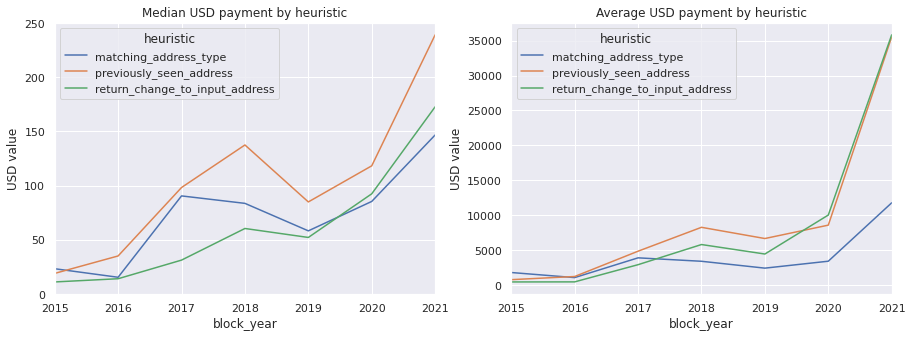

In [35]:
usd_dt = usd_by_heuristic.set_index(
    pd.DatetimeIndex(usd_by_heuristic['block_year'])
).drop('block_year', axis=1)

figure, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_ylabel("USD value")
axes[1].set_ylabel("USD value")
df1 = usd_dt.pivot(columns='heuristic')['2014-10':'2021-12']['approx_median_payment_usd'].plot(ax=axes[0], title="Median USD payment by heuristic")
df2 = usd_dt.pivot(columns='heuristic')['2014-10':'2021-12']['average_payment_usd'].plot(ax=axes[1], title="Average USD payment by heuristic")

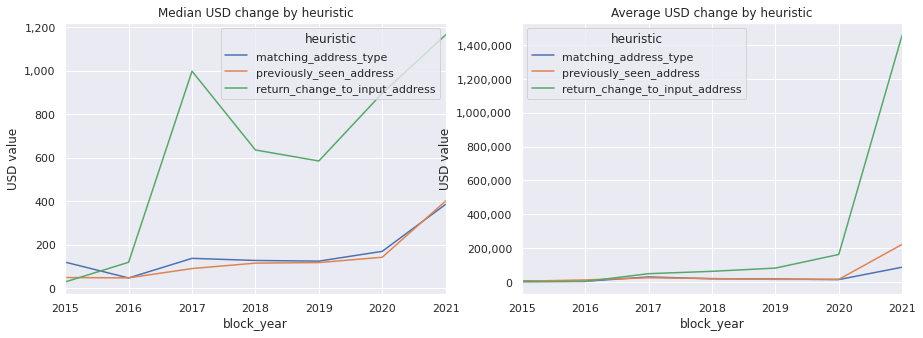

In [36]:
figure, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_ylabel("USD value")
axes[1].set_ylabel("USD value")
df1 = usd_dt.pivot(columns='heuristic')['2014-10':'2021-12']['approx_median_change_usd'].plot(ax=axes[0], title="Median USD change by heuristic")
df2 = usd_dt.pivot(columns='heuristic')['2014-10':'2021-12']['average_change_usd'].plot(ax=axes[1], title="Average USD change by heuristic")

axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Transactions By Hour Of Day

Simple graph to verify that transactions follow some sort of temporal pattern. Not very interesting on it's own, but perhaps worthy of further investigation

In [32]:
%%bigquery tx_by_hour
SELECT extract(hour from block_timestamp) block_hour
     , count(*) as tx_by_hour
  FROM `bitcoin-data-analysis-320014.transaction_analysis.txs_two_or_less_outputs`
GROUP BY 1

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 17.11rows/s]


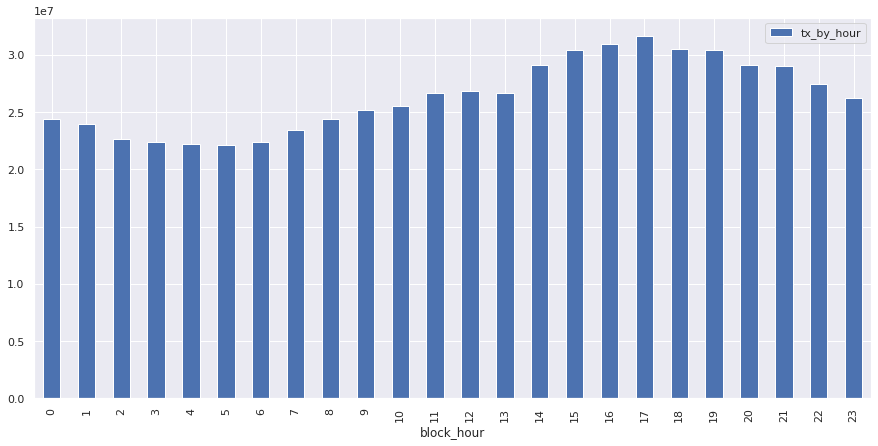

In [33]:
tx_by_hour.set_index('block_hour').sort_index().plot(kind='bar', figsize=(15,7));